In [39]:
import os
import sys
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Scoring
from BorutaShap import BorutaShap
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

In [40]:
computed_features = 'data/data_202110/hjolli_bin_df1.csv'           
jaspar = 'data/data_202110/hjolli_motifs1.csv' 
motifs_file = 'data/data_202110/hjolli_motifs_score1.csv'
informations = 'data/data_202110/hjolli1.csv'
sequence = 'data/hjolli_dataset_robin_value_600.csv'

In [41]:
df_cf = pd.read_csv(computed_features, sep=',')
df_jaspar = pd.read_csv(jaspar, sep=',')
df_seq = pd.read_csv(sequence, sep='\t')
df_cf = df_cf.drop(columns='Unnamed: 0')
df_cf = df_cf.drop(columns='n_motif_bin')
motifs = pd.read_csv(motifs_file, sep=',')
cage_i = pd.read_csv(informations, sep=',')
info_ = pd.concat([motifs, df_cf], axis=1)
info_.rename(columns={'Unnamed: 0':'thick.names'}, inplace=True)
df_jaspar.rename(columns={'Unnamed: 0':'thick.names'}, inplace=True)

In [43]:
#cage_i['adjusted_log10_CV2'].quantile([0.25, 0.30, 0.50, 0.75])

0.25   -0.149008
0.30   -0.115816
0.50   -0.000232
0.75    0.192239
Name: adjusted_log10_CV2, dtype: float64

In [44]:
#cage_i.loc[cage_i['adjusted_log10_CV2'] <= -0.149008, 'Class_'] = 0
#cage_i.loc[cage_i['adjusted_log10_CV2'] >= 0.192239, 'Class_'] = 1

cage_i.loc[cage_i['adjusted_log10_CV2'] <= -0.20, 'Class_'] = 0
cage_i.loc[cage_i['adjusted_log10_CV2'] >= 0.25, 'Class_'] = 1
cage_i["log10_median"] = np.log(cage_i['median']+1)
promoter_variability = cage_i.dropna()

In [61]:
promoter_variability.head()

,seqnames,start,end,width,strand,score,thick.start,thick.end,thick.width,thick.names,...,entropy,IQR,PhastCon,CpG,CpG.obsexp,Class_,log10_median,new_start,new_end,Region
0,chr1,629079,629397,319,+,134749,629129,629129,1,chr1:629079-629397;+,...,5.835915,70,0.554232,1,0.545710,1.0,3.692134,628938,629538,chr1:628938-629538
1,chr1,629472,629557,86,+,5761,629504,629504,1,chr1:629472-629557;+,...,1.592665,0,0.779070,1,0.626652,1.0,0.679697,629214,629814,chr1:629214-629814
2,chr1,629627,630904,1278,+,895012,630752,630752,1,chr1:629627-630904;+,...,7.010044,467,0.430908,1,0.596374,1.0,5.725004,629965,630565,chr1:629965-630565
3,chr1,631043,631657,615,+,1706302,631073,631073,1,chr1:631043-631657;+,...,5.452198,404,0.798862,1,0.532787,1.0,6.142378,631050,631650,chr1:631050-631650
4,chr1,631719,633168,1450,+,2302901,632759,632759,1,chr1:631719-633168;+,...,5.843819,813,0.754000,1,0.944569,1.0,6.688405,632143,632743,chr1:632143-632743


In [46]:
promoter_variability['new_start'] = ((promoter_variability.start+promoter_variability.end)//2)-300
promoter_variability['new_end'] = ((promoter_variability.start+promoter_variability.end)//2)+300

In [47]:
promoter_variability['Region'] = promoter_variability.agg('{0[seqnames]}:{0[new_start]}-{0[new_end]}'.format, axis=1)

In [48]:
promoter_variability_tmp = promoter_variability[['Region','thick.names', 'seqnames', 'geneID', 'log10_median','median','adjusted_log10_CV2','Class_']]
promoter_variability_tmp

,Region,thick.names,seqnames,geneID,log10_median,median,adjusted_log10_CV2,Class_
0,chr1:628938-629538,chr1:629079-629397;+,chr1,ENSG00000225972.1,3.692134,39.130407,0.993507,1.0
1,chr1:629214-629814,chr1:629472-629557;+,chr1,ENSG00000225630.1,0.679697,0.973279,1.515555,1.0
2,chr1:629965-630565,chr1:629627-630904;+,chr1,ENSG00000225630.1,5.725004,305.434634,0.539849,1.0
3,chr1:631050-631650,chr1:631043-631657;+,chr1,ENSG00000237973.1,6.142378,464.158444,0.947539,1.0
4,chr1:632143-632743,chr1:631719-633168;+,chr1,ENSG00000229344.1,6.688405,802.040196,0.483100,1.0
...,...,...,...,...,...,...,...,...
28996,chrY:3002493-3003093,chrY:3002785-3002802;-,chrY,ENSG00000233070.1,0.000000,0.000000,0.274631,1.0
28997,chrY:13479168-13479768,chrY:13479297-13479640;-,chrY,ENSG00000183878.15,0.319594,0.376568,0.419294,1.0
28998,chrY:13479661-13480261,chrY:13479736-13480187;-,chrY,ENSG00000183878.15,1.283370,2.608779,0.937610,1.0
28999,chrY:19077133-19077733,chrY:19077321-19077546;-,chrY,ENSG00000176728.7,0.000000,0.000000,0.765401,1.0


# merge dataframes to have all info in one place

In [49]:
final_df_tmp = promoter_variability_tmp.merge(df_jaspar, how='inner',on='thick.names')
final_df_tmp.rename(columns={'seqnames':'Chr'}, inplace=True)

In [50]:
final_df_tmp.head()

,Region,thick.names,Chr,geneID,log10_median,median,adjusted_log10_CV2,Class_,Mafb,RORC,...,ZNF16,TBX19,BACH2(var.2),NR1H2::RXRA,RARA,POU4F2,Sox11,SRF,ZNF382,CpG
0,chr1:628938-629538,chr1:629079-629397;+,chr1,ENSG00000225972.1,3.692134,39.130407,0.993507,1.0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,chr1:629214-629814,chr1:629472-629557;+,chr1,ENSG00000225630.1,0.679697,0.973279,1.515555,1.0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,chr1:629965-630565,chr1:629627-630904;+,chr1,ENSG00000225630.1,5.725004,305.434634,0.539849,1.0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,chr1:631050-631650,chr1:631043-631657;+,chr1,ENSG00000237973.1,6.142378,464.158444,0.947539,1.0,1,1,...,0,0,0,0,0,0,0,0,0,1
4,chr1:632143-632743,chr1:631719-633168;+,chr1,ENSG00000229344.1,6.688405,802.040196,0.483100,1.0,1,1,...,0,0,0,0,0,0,0,0,0,1


In [51]:
final_df = final_df_tmp.merge(df_seq[['Fold', 'Region']], how='inner',on='Region')

In [62]:
final_df

,Region,thick.names,Chr,geneID,log10_median,median,adjusted_log10_CV2,Class_,Mafb,RORC,...,TBX19,BACH2(var.2),NR1H2::RXRA,RARA,POU4F2,Sox11,SRF,ZNF382,CpG,Fold
0,chr1:628938-629538,chr1:629079-629397;+,chr1,ENSG00000225972.1,3.692134,39.130407,0.993507,1.0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,chr1:629214-629814,chr1:629472-629557;+,chr1,ENSG00000225630.1,0.679697,0.973279,1.515555,1.0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,chr1:629965-630565,chr1:629627-630904;+,chr1,ENSG00000225630.1,5.725004,305.434634,0.539849,1.0,1,1,...,0,0,0,0,0,0,0,0,1,0
3,chr1:631050-631650,chr1:631043-631657;+,chr1,ENSG00000237973.1,6.142378,464.158444,0.947539,1.0,1,1,...,0,0,0,0,0,0,0,0,1,0
4,chr1:632143-632743,chr1:631719-633168;+,chr1,ENSG00000229344.1,6.688405,802.040196,0.483100,1.0,1,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10739,chrY:3002493-3003093,chrY:3002785-3002802;-,chrY,ENSG00000233070.1,0.000000,0.000000,0.274631,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
10740,chrY:13479168-13479768,chrY:13479297-13479640;-,chrY,ENSG00000183878.15,0.319594,0.376568,0.419294,1.0,1,1,...,0,0,0,0,0,0,0,0,1,0
10741,chrY:13479661-13480261,chrY:13479736-13480187;-,chrY,ENSG00000183878.15,1.283370,2.608779,0.937610,1.0,1,0,...,0,0,0,0,0,0,0,0,1,0
10742,chrY:19077133-19077733,chrY:19077321-19077546;-,chrY,ENSG00000176728.7,0.000000,0.000000,0.765401,1.0,1,1,...,0,0,0,0,0,0,0,0,1,0


In [52]:
train_df = final_df.loc[final_df['Fold'] != 5]

In [53]:
params = {'max_depth': 10,
          'min_samples_leaf': 50,
          'min_samples_split': 50,
          'class_weight' : 'balanced', 
          'n_jobs' : -1,
          'n_estimators': 500}

In [54]:
forest = RandomForestClassifier(**params)

In [55]:
# no model selected default is Random Forest, if classification is True it is a Classification problem
Feature_Selector = BorutaShap(model=forest, 
                              importance_measure ='Shap',
                              classification=True)
# take column needed for the prediction 
X = train_df.iloc[:, 8:-1]
Y = train_df.iloc[:, 7]
Feature_Selector.fit(X=X, y=Y, n_trials=100, sample=False, train_or_test = 'test', normalize=True, verbose=True)


100%|██████████| 100/100 [2:10:14<00:00, 78.15s/it] 

125 attributes confirmed important: ['TBX3', 'ZNF341', 'TFAP2C(var.2)', 'Hic1', 'GCM2', 'HIF1A', 'NOTO', 'FLI1', 'Dux', 'ZNF317', 'ZNF148', 'ETV2', 'FOXD2', 'VEZF1', 'KLF4', 'FERD3L', 'NR2C1', 'MZF1', 'HOXD9', 'SOX4', 'Ascl2', 'ELK4', 'ELF5', 'BATF', 'TBX6', 'ELK3', 'FOXO6', 'MZF1(var.2)', 'Rbpjl', 'FEV', 'Pax2', 'SNAI1', 'KLF10', 'ZBTB7A', 'RFX7', 'TBX4', 'GMEB2', 'HINFP', 'Foxj2', 'GLIS2', 'FOXP2', 'TFAP2B', 'MSANTD3', 'MYF5', 'Ahr::Arnt', 'ERF', 'TFAP2A(var.2)', 'Zic2', 'CREB3L4(var.2)', 'ELK1', 'HOXA10', 'SOX8', 'NKX6-2', 'ZFP42', 'BATF3', 'TWIST1', 'TCFL5', 'NRF1', 'TFAP4', 'Gmeb1', 'Klf1', 'ZNF449', 'SOX10', 'FOS', 'ATOH1(var.2)', 'Ebf2', 'IKZF1', 'YY2', 'Smad2::Smad3', 'ZFP57', 'VAX1', 'MGA', 'Wt1', 'HES2', 'Dlx1', 'FOXC2', 'ELF4', 'Ptf1a', 'TFAP2B(var.2)', 'OSR2', 'ZIC1', 'FOSL1::JUND', 'Atf1', 'MYOG', 'Ptf1a(var.3)', 'Zfx', 'SRY', 'RBPJ', 'ARNT::HIF1A', 'KLF17', 'ETV5', 'SPDEF', 'NKX2-5', 'ETV3', 'ETV6', 'ZIC5', 'NFATC1', 'YY1', 'TBP', 'TFDP1', 'OSR1', 'Ptf1a(var.2)', 'ETS2', 

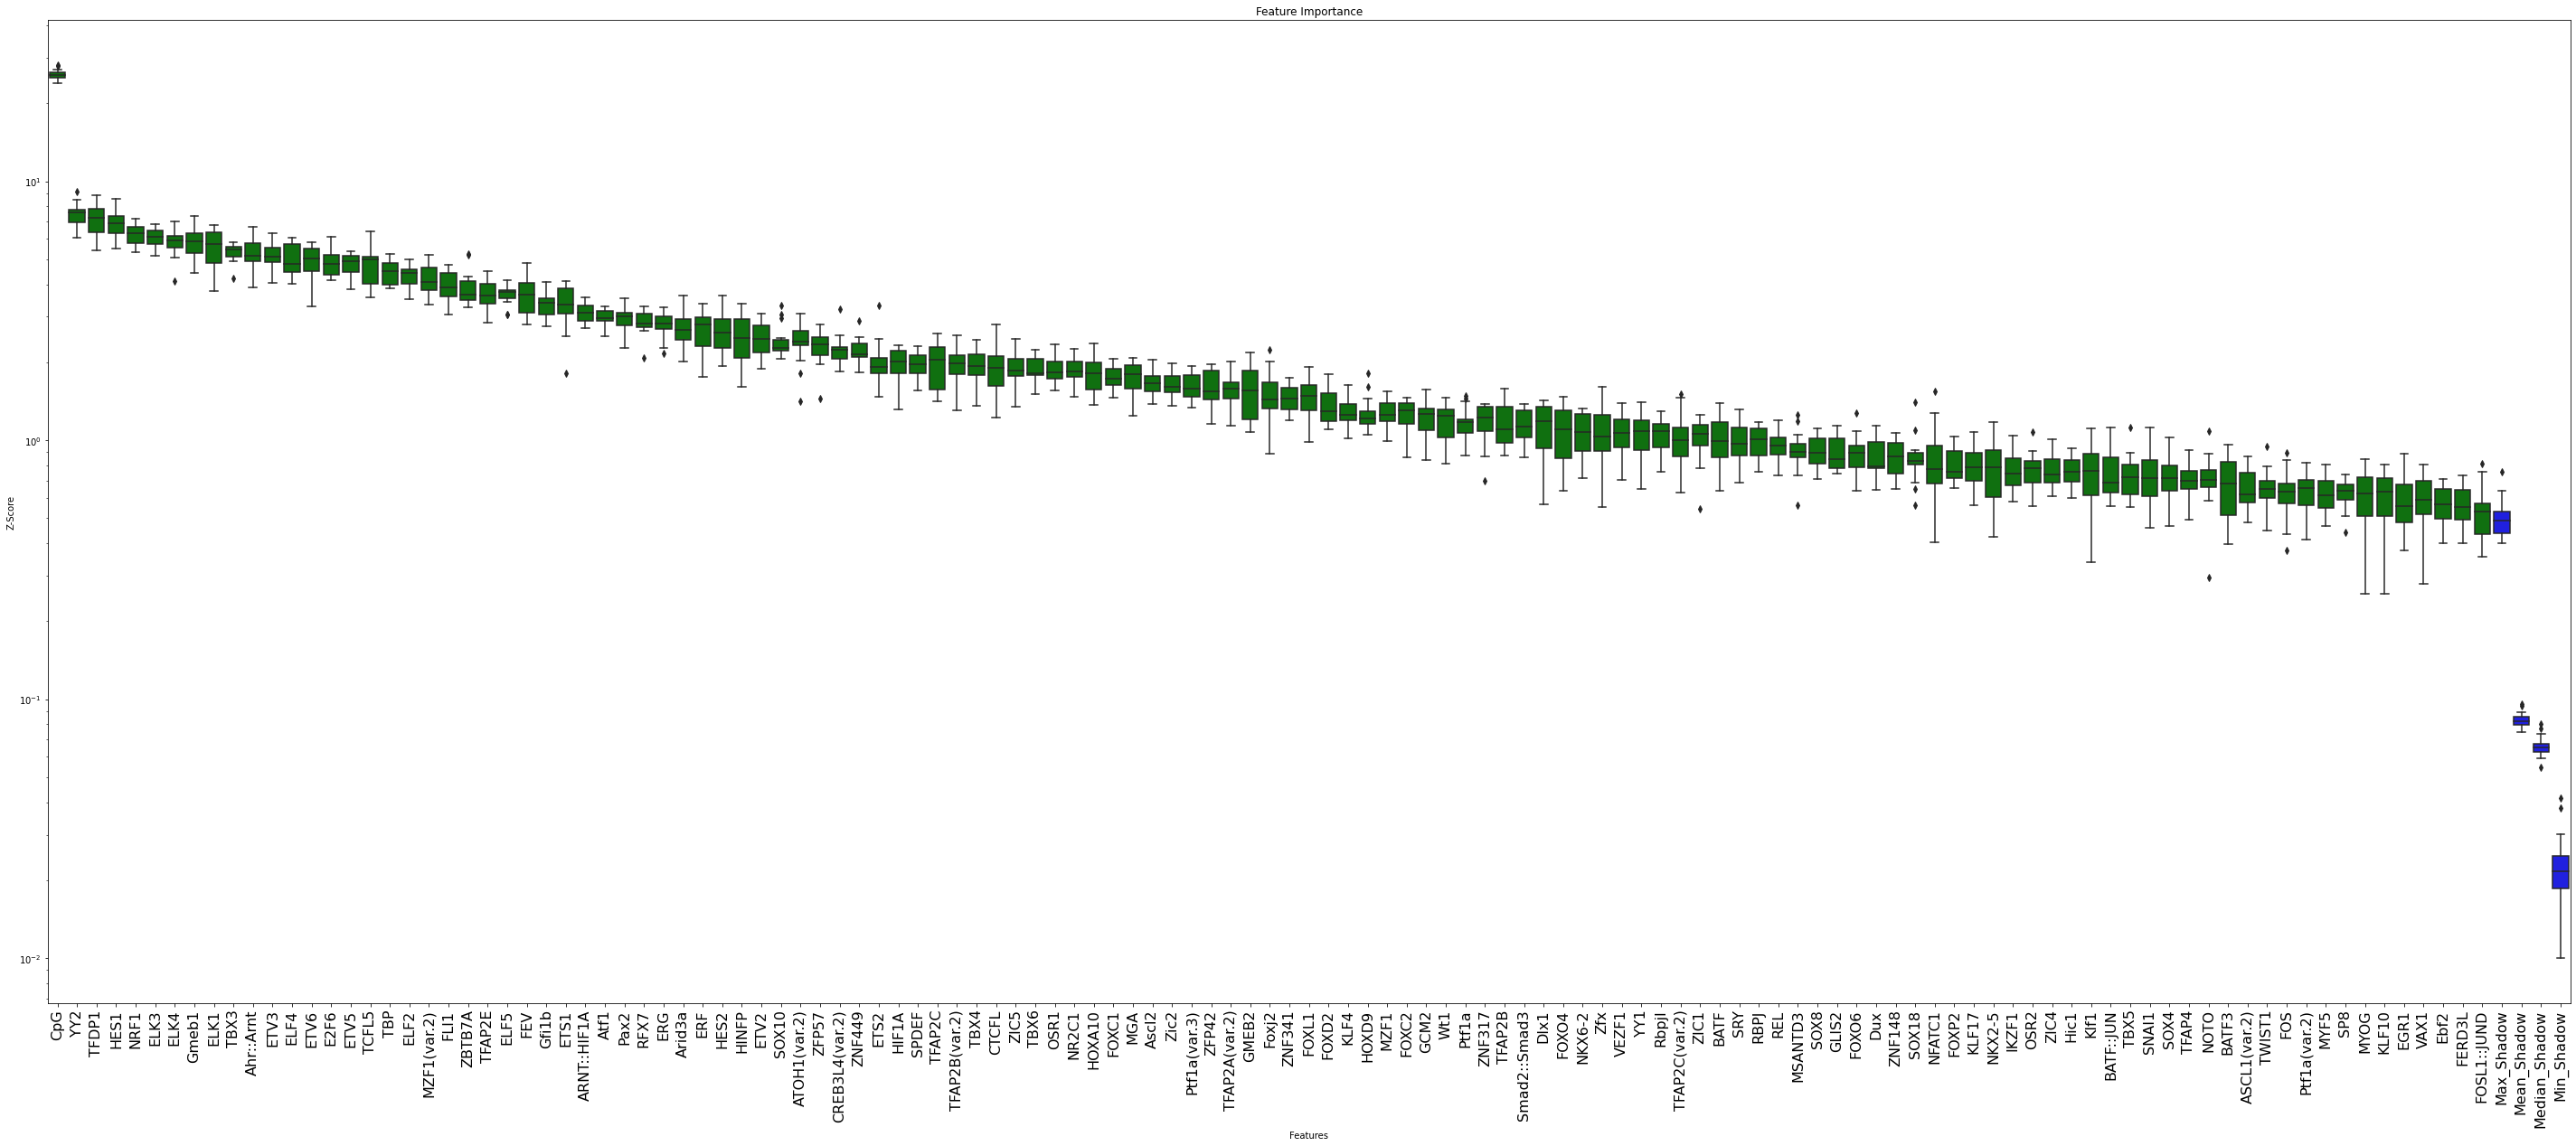

In [69]:
Feature_Selector.plot(X_size=16, figsize=(50, 20), which_features='accepted')
#plt.savefig('data/plots/boruta_high.png', dpi=500)

In [59]:
Feature_Selector.results_to_csv(filename='data/feature_importance')

In [58]:
subset = Feature_Selector.Subset()
subset.head()

,TBX3,ZNF341,TFAP2C(var.2),Hic1,GCM2,HIF1A,NOTO,FLI1,Dux,ZNF317,...,Arid3a,BATF::JUN,SP8,Gfi1b,HES1,CTCFL,FOXL1,TFAP2E,ASCL1(var.2),ELF2
0,0,1,1,1,0,0,1,0,1,1,...,1,1,1,0,0,0,1,1,1,0
1,1,0,0,1,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,0,1,0,1,0,1,1,1,1,1,...,1,1,1,1,0,0,1,1,1,0
3,0,1,0,1,0,0,1,0,1,1,...,1,1,1,1,1,0,1,1,1,0
4,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
